In [7]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import balanced_accuracy_score, mean_absolute_error
%matplotlib inline 

In [3]:
# color dict (use: colors['XColor'])
import ast
with open('color_palette.txt', 'r') as file:
    contents = file.read()
    colors = ast.literal_eval(contents)

In [4]:
rdrive = '/mnt/researchdrive/BOX_INTERNAL/opotowsky/'
mll_gam = rdrive + 'mll/gam_spec/'
mll_nuc = rdrive + 'mll/nuc_conc/'
learn_gam = rdrive + 'scikit/gam_spec/'
learn_nuc = rdrive + 'scikit/nuc_conc/'

In [5]:
# uncertainty for both MLL and Scikit are now sqrt(counts), but implemented differently (std dev versus rand err method in scikit)
# nuc and act trainsets use flat 5% unc/rand err
# 6.7% of the train set is reserved as test set (randomly in each case, but also implemented differently)

In [6]:
df = pd.read_csv(learn_gam + 'act32/reactor_dtree_tset1.0_act32_mimic_mll.csv').drop(columns='Unnamed: 0')
df['TrueY'].describe()['count']

29520

In [15]:
pwr = df.loc[df['TrueY'] == 'pwr']
bwr = df.loc[df['TrueY'] == 'bwr']
phwr = df.loc[df['TrueY'] == 'phwr']

In [16]:
total = df['TrueY'].describe()['count']
pwrfrac = len(pwr)/total
bwrfrac = len(bwr)/total
phwrfrac = len(phwr)/total
pwrfrac, bwrfrac, phwrfrac

(0.22437978041827777, 0.7629194772938952, 0.012700742287827044)

In [17]:
pwrfrac*pwrfrac + bwrfrac*bwrfrac + phwrfrac*phwrfrac

0.6325537235496066

In [18]:
accuracy_score(df['TrueY'], df['DTree'])

0.981202901414016

In [19]:
balanced_accuracy_score(df['TrueY'], df['DTree'], adjusted=True)

0.969895375966735

In [5]:
dets = ['nuc29', 'act32', 'act4/9', 'd1_hpge', 'd2_hpge', 'd3_czt', 'd6_sri2', 'd5_labr3', 'd4_nai']
pred = ['reactor', 'burnup', 'enrichment', 'cooling']
predmll = ['ReactorType', 'Burnup', 'Enrichment', 'CoolingTime']
csv_end = '_mimic_mll.csv'
# for dataframes
algcol = ['knn31', 'dtree31', 'mll31', 'knn113', 'dtree113', 'mll113', 'knn_auto', 'dtree_auto', 'mll_auto']
scrcol  = ['Accuracy', 'Acc Std']
errcol = ['Neg MAE', 'MAE Std']
tfrac = '_tset1.0_'

## Results for Box Plots

In [ ]:
#with open(rdrive + 'mll_scikit_compare_abs_errors.pkl', 'rb') as handle:
#    results = pickle.load(handle)

In [ ]:
#def boxplot(pred, en_list):
#    return

## Results for Error Bar Plots

In [19]:
with open(rdrive + 'mll_scikit_compare.pkl', 'rb') as handle:
    results = pickle.load(handle)

In [20]:
results['reactor']

Algorithm  knn_auto           dtree_auto            mll_auto             \
Metric     Accuracy   Acc Std   Accuracy   Acc Std  Accuracy    Acc Std   
nuc29      0.970015  0.141194   0.969496  0.138187  0.989195   0.082082   
act32      0.985293  0.103231   0.979468  0.120904  0.996973  0.0477847   
act4/9     0.848518  0.250212   0.871051  0.251671  0.982768   0.112564   
d1_hpge    0.309496  0.411747   0.683224  0.340597   0.86773   0.256574   
d2_hpge    0.284731  0.416559    0.65299  0.356712  0.822084   0.296186   
d3_czt     0.467737  0.403966   0.513984  0.392527  0.756621   0.314668   
d6_sri2    0.692461  0.327352    0.61474  0.357707   0.77264   0.297984   
d5_labr3   0.655347  0.342912   0.562001  0.377903  0.753908   0.305716   
d4_nai     0.495306  0.380379   0.448124  0.411864  0.647745    0.36459   

Algorithm     knn31             dtree31               mll31             \
Metric     Accuracy   Acc Std  Accuracy   Acc Std  Accuracy    Acc Std   
nuc29      0.970015  0.141194  0.969496  0.138187  0.989195   0.082082   
act32      0.985293  0.103231  0.979468  0.120904  0.996973  0.0477847   
act4/9     0.483654  0.392072   0.52543  0.393857  0.907018   0.229933   
d1_hpge    0.728481   0.32292   0.70057  0.333394  0.796693   0.299628   
d2_hpge    0.695582  0.337105  0.689053  0.337253  0.751692   0.311445   
d3_czt      0.61925  0.359124  0.598429  0.375329  0.709409   0.335126   
d6_sri2    0.633169  0.342912  0.599499  0.366197  0.721301   0.324458   
d5_labr3   0.622069  0.343701   0.56612  0.368915  0.711033   0.320219   
d4_nai     0.540868  0.361665  0.577727  0.381617   0.70419   0.346702   

Algorithm    knn113            dtree113              mll113             
Metric     Accuracy   Acc Std  Accuracy   Acc Std  Accuracy    Acc Std  
nuc29      0.970015  0.141194  0.969496  0.138187  0.989195   0.082082  
act32      0.985293  0.103231  0.979468  0.120904  0.996973  0.0477847  
act4/9     0.848518  0.250212  0.871051  0.251671  0.982768   0.112564  
d1_hpge    0.724762  0.323599  0.774049  0.303762  0.855093    0.26411  
d2_hpge    0.625286  0.347701  0.735925   0.32042  0.802179   0.301168  
d3_czt     0.616621  0.358137  0.630315  0.359223  0.737563   0.317588  
d6_sri2    0.621772  0.336361  0.690703  0.338878  0.767684   0.300671  
d5_labr3   0.631769  0.339648  0.632913   0.35873  0.760115   0.302562  
d4_nai     0.534409  0.361471  0.557042   0.37634  0.693692   0.343201

# Plotting

In [21]:
x = ['Nuc29', 'Act32', 'Act4/9', 'L/HPGe', 'P/HPGe', 'CZT', 'SrI2', 'LaBr3', 'NaI']
_x = np.arange(len(x))
d_x = [-0.2, 0, 0.2]
ens = ['_auto', '31', '113']
en_lbl = ['Auto', '31', '113']
algs = ['dtree', 'knn', 'mll']
alg_lbl = ['Dec Tree', 'kNN', 'MLL Calc']
c_ens = ['M', 'M', 'M']
c_algs = ['L', 'M', 'D']
c = ['Teal', 'Brwn', 'Purp']

In [22]:
def plot_by_enlist(a, ax, fig, plotdf, metric, std):
    ax.set_title(en_lbl[a]+' Energy Windows', fontsize=16)
    for i in range(0,3):
        y = np.array(plotdf[algs[i]+ens[a]][metric], dtype=float)
        sd = np.array(plotdf[algs[i]+ens[a]][std], dtype=float)
        _, _, bars = ax.errorbar(_x+d_x[i], y, yerr=sd, color=colors[c_ens[i]+c[i]], marker='o', linestyle='None', mew=0, ms=7, elinewidth=3, label=alg_lbl[i])
        plt.xticks(_x, x)
        [bar.set_alpha(0.4) for bar in bars]
        #ax.plot(x, y, 'o-', color=colors[c_ens[i]+c[i]], mew=0, ms=5, label=alg_lbl[i])
        #ax.fill_between(x, y - sd, y + sd, color=colors[c_ens[i]+c[i]], alpha=0.35)
    ax.legend(loc='lower center', ncol=3)
    return fig

def plot_by_alg(a, ax, fig, plotdf, metric, std):
    ax.set_title(alg_lbl[a], fontsize=16)
    for i in range(0,3):
        y = np.array(plotdf[algs[a]+ens[i]][metric], dtype=float)
        sd = np.array(plotdf[algs[a]+ens[i]][std], dtype=float)
        _, _, bars = ax.errorbar(_x+d_x[i], y, yerr=sd, color=colors[c_algs[i]+c[a]], marker='o', linestyle='None', mew=0, ms=7, elinewidth=3, label=en_lbl[i])
        [bar.set_alpha(0.4) for bar in bars]
        plt.xticks(_x, x)
        #ax.plot(x, y, 'o-', color=colors[c_algs[i]+c[a]], mew=0, ms=5, label=en_lbl[i])
        #ax.fill_between(x, y - sd, y + sd, color=colors[c_algs[i]+c[a]], alpha=0.35)
    ax.legend(loc='lower center', title='Energy Windows', ncol=3)
    return fig

In [23]:
def plot(pred_param, title, plttype):
    plt.clf()
    fig, axs = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True, figsize=(18,6))
    axs[1].set_xlabel('Detector Type', fontsize=20, labelpad=15)
    if pred_param == 'reactor':
        axs[0].set_ylabel('Accuracy Score', fontsize=20, labelpad=15)
        metric = scrcol[0]
        std = scrcol[1]
    else:
        err = 'Negative MAE'
        if pred_param == 'burnup':
            yaxlbl = err + ' [MWd/MTU]'
        elif pred_param == 'enrichment':
            yaxlbl = err + ' [% U235]'
        else:
            yaxlbl = err + ' [days]'
        axs[0].set_ylabel(yaxlbl, fontsize=20, labelpad=15)
        metric = errcol[0]
        std = errcol[1]
    
    plotdf = results[pred_param]
    for a, ax in enumerate(axs):
        if plttype == 'enlist':
            plot_by_enlist(a, ax, fig, plotdf, metric, std)
        else:
            plot_by_alg(a, ax, fig, plotdf, metric, std)
        ax.tick_params(labelsize=12, labelrotation=45)
        if pred_param == 'cooling': 
            ax.set_ylim(-350, 49)
    
    fig.suptitle(title, fontsize=22)
    fig.subplots_adjust(top=.85)
    plt.show()
    
    #sv_fig = './plots/fb_detector_preds_wrt_' + plttype + '_' + pred_param + '.png'
    #fig.savefig(sv_fig, bbox_inches='tight', transparent=True)

<Figure size 432x288 with 0 Axes>

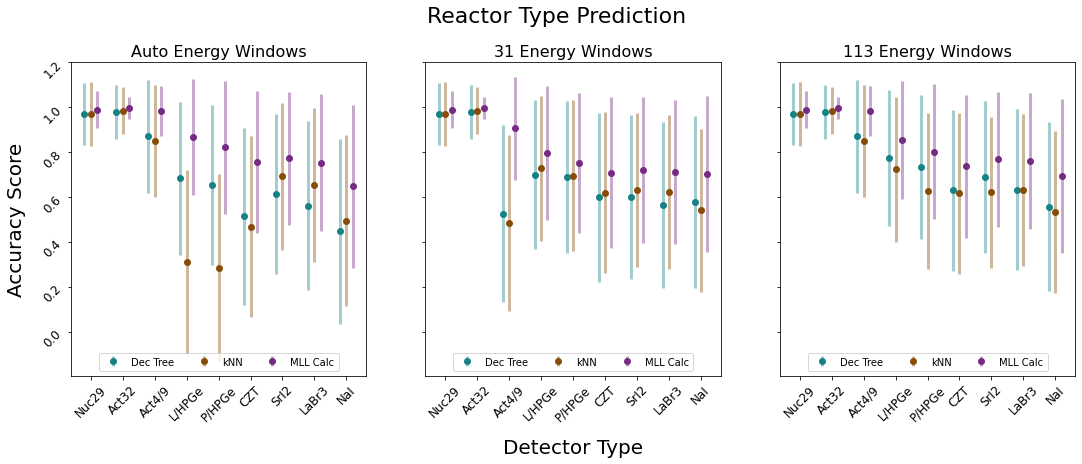

<Figure size 432x288 with 0 Axes>

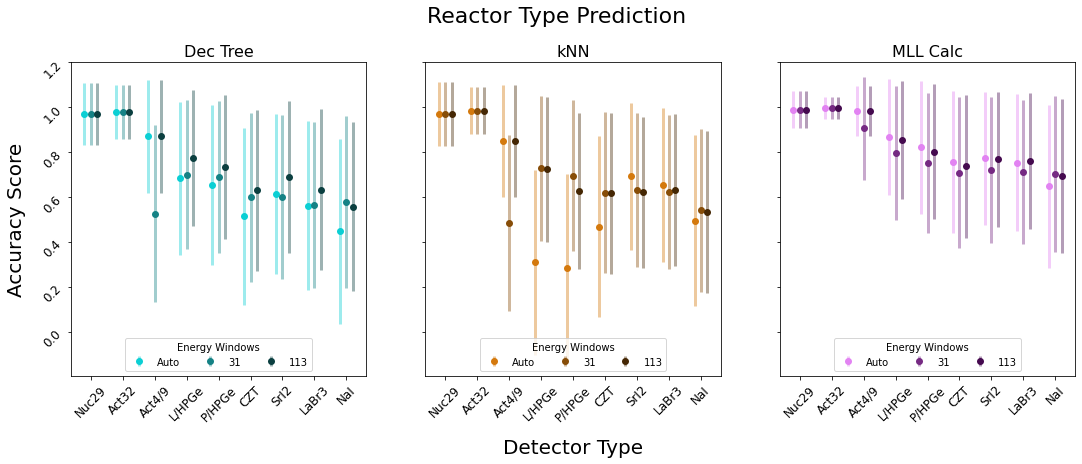

In [24]:
plot('reactor', 'Reactor Type Prediction', 'enlist')
plot('reactor', 'Reactor Type Prediction', 'alg')
# balanced accuracy score now used

<Figure size 432x288 with 0 Axes>

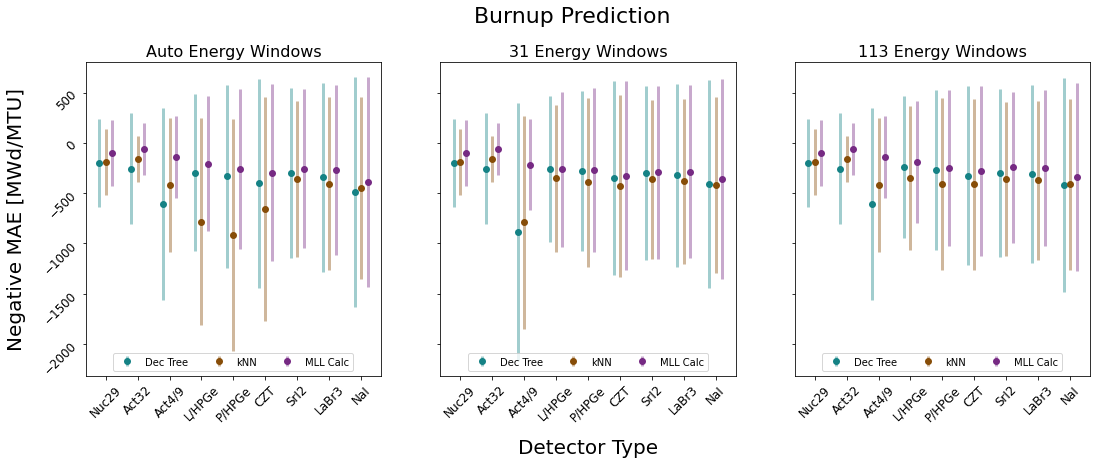

<Figure size 432x288 with 0 Axes>

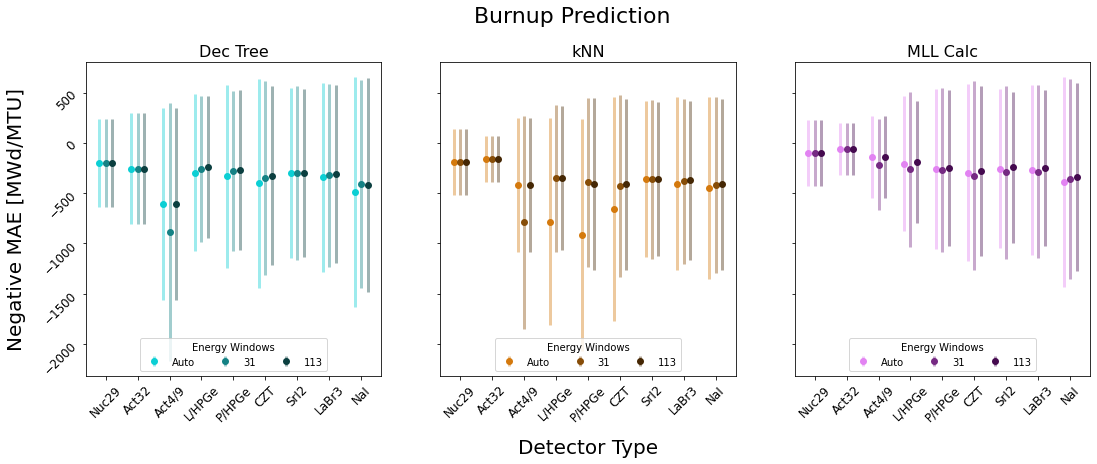

In [25]:
plot('burnup', 'Burnup Prediction', 'enlist')
plot('burnup', 'Burnup Prediction', 'alg')

<Figure size 432x288 with 0 Axes>

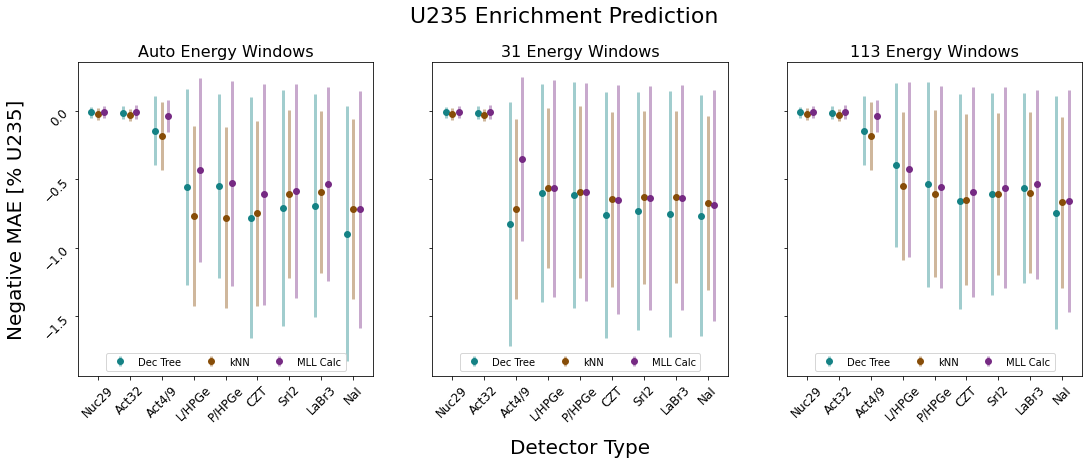

<Figure size 432x288 with 0 Axes>

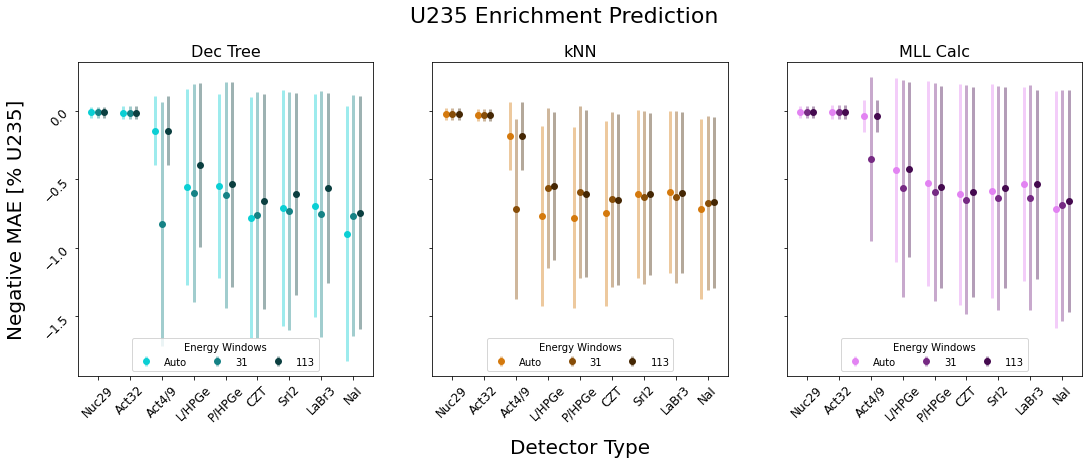

In [26]:
plot('enrichment', 'U235 Enrichment Prediction', 'enlist')
plot('enrichment', 'U235 Enrichment Prediction', 'alg')

<Figure size 432x288 with 0 Axes>

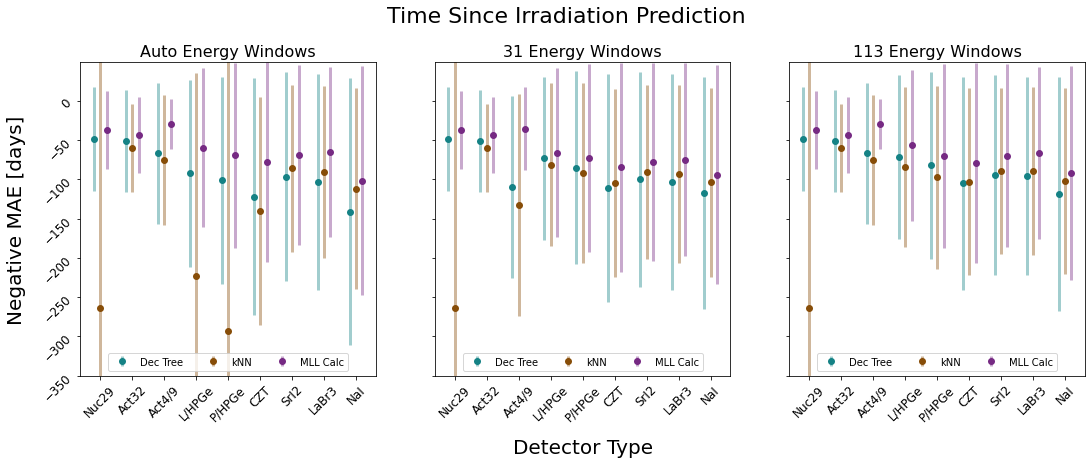

<Figure size 432x288 with 0 Axes>

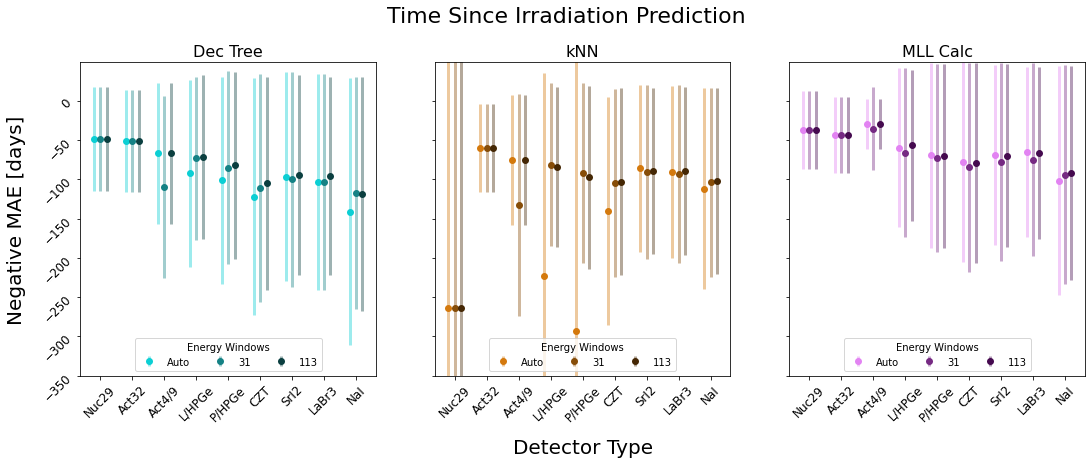

In [27]:
plot('cooling', 'Time Since Irradiation Prediction', 'enlist')
plot('cooling', 'Time Since Irradiation Prediction', 'alg')

In [28]:
# using more trainset for knn makes a huge difference. 
#this high error for knn for cooling time/nuc29 is easily resolved